<a href="https://colab.research.google.com/github/MohamedElWaghf/Projet-Long/blob/master/SimpleCNN_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
import matplotlib.pyplot as plt
%matplotlib inline 
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
import cv2
from keras.regularizers import l2
from keras.layers import Input
import keras
from keras.preprocessing import image

In [3]:
def gray2RGB(x):
    if len(x.shape)==2:
        return np.stack((x,x,x),-1)
    else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
    return x

In [4]:
image_size=(64, 64)
from tqdm import tqdm
def load_fer2013(dataset_path,image_size=(48,48),util='Training'):

  data = pd.read_csv(dataset_path)
  data=data[data['Usage']==util]
  pixels = data['pixels'].tolist()
  width, height = 48, 48
  faces = []
  new_faces=[]
  for pixel_sequence in tqdm(pixels):

    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'), image_size)
    faces.append(face.astype('float32'))
    

  faces = np.asarray(faces)
  faces = np.expand_dims(faces, -1)
  print(faces.shape)
  print(faces[1].shape)
 
  emotions = to_categorical(data.emotion)
  new_faces = np.asarray(new_faces)
  return faces, emotions

In [5]:
data_path="/content/drive/MyDrive/fer20131.csv"

In [5]:
X,y_t=load_fer2013(data_path,image_size=(224,224))

100%|██████████| 28709/28709 [00:26<00:00, 1095.12it/s]


(28709, 224, 224, 1)
(224, 224, 1)


In [6]:
X_val,y_val=load_fer2013(data_path,image_size=(224,224),util='PublicTest')

100%|██████████| 3589/3589 [00:03<00:00, 1175.88it/s]


(3589, 224, 224, 1)
(224, 224, 1)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.2, random_state=42)

In [6]:
def load_data(sample_split=0.3,img_size=(48,48), usage='Training',classes=['Angry','Happy'], filepath='/content/drive/MyDrive/fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in tqdm(range(len(x))):
        face = [int(num) for num in x[i].split()]
        #X.append(each_pixel)
        #face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(48, 48)
        face = cv2.resize(face.astype('uint8'), img_size)
        X.append(face.astype('float32'))
    ## reshape into 48*48*1 and rescale
    X = np.asarray(X)
    X = np.expand_dims(X, -1)
    #X = np.array(X)
    #X = X.reshape(X.shape[0], 64, 64,1)
    #X = X.astype("float32")
    X /= 255
    
    y_train = data.emotion
    y_train = to_categorical(y_train)
    return X, y_train

In [7]:
## All three datasets are well loaded accordingly
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Disgust', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

In [8]:
from tqdm import tqdm 
X_test, y_test = load_data(sample_split=1.0,img_size=(64,64),classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,img_size=(64,64),classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,img_size=(64,64),classes=emo,
usage= 'PublicTest')

100%|██████████| 3589/3589 [00:02<00:00, 1334.93it/s]


In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 64, 64, 1)
(28709, 7)
(3589, 64, 64, 1)
(3589, 7)
(3589, 64, 64, 1)
(3589, 7)


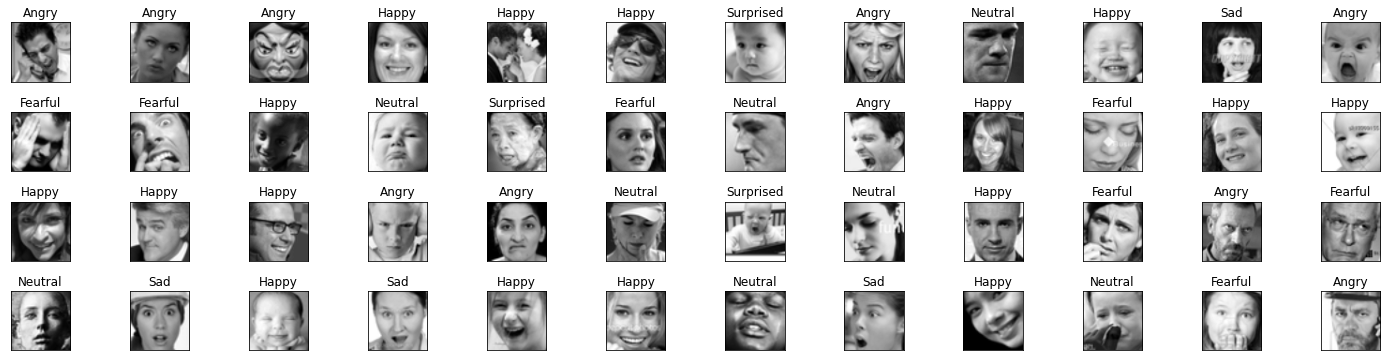

In [11]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

def overview(start, end, X,y):
    """
    The function is used to plot first several pictures for overviewing inputs format
    """
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        pred=y[i:(i+1)]
        labelindex=int(np.argmax(pred))
        label=emotion_dict[labelindex]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
        plt.title(label)
    plt.show()
overview(0,47, X_train,y_train)

In [ ]:
import keras 
from keras.layers import BatchNormalization, GlobalAveragePooling2D
import tensorflow as tf
 #vgg_model = tf.keras.applications.VGG16(weights='imagenet',input_shape=[IMG_SIZE,IMG_SIZE,1], include_top=False)
model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.summary()


loss = tf.keras.losses.CategoricalCrossentropy()# Defining the optimizer
#adam = tf.keras.optimizers.Adam(learning_rate=0.0001)# Compiling the model
model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])

In [ ]:
# Plot model graph
tf.keras.utils.plot_model(model, to_file='Model1.png')
from IPython.display import Image
Image(retina=True, filename='Model1.png')

In [ ]:
from keras.callbacks import  ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [ ]:
early_stop = EarlyStopping('val_loss', patience=60)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=12, verbose=1,min_lr=1e-5)
callbacks = [early_stop, reduce_lr]

In [ ]:
nb_epochs = 1000
batch_size = 64
#64

#modelF = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
#          validation_data=(X_val, y_val), shuffle=True, verbose=1)
model.fit_generator(data_generator.flow(X_train, y_train,
                                            batch_size),
                        steps_per_epoch=len(X_train) / batch_size,
                        epochs=nb_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(X_val,y_val))

In [ ]:
hist = model.fit(X_train,y_train,batch_size=64,
                           validation_data = (X_val,y_val),
                           epochs = 1000,callbacks=callbacks)

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model




In [ ]:
model=mini_XCEPTION(input_shape=(64, 64, 1),num_classes=7)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
print ('Training....')
#fit
nb_epochs = 1000
batch_size = 64
#64

#modelF = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
#          validation_data=(X_val, y_val), shuffle=True, verbose=1)
model.fit_generator(data_generator.flow(X_train, y_train,
                                            batch_size),
                        steps_per_epoch=len(X_train) / batch_size,
                        epochs=nb_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(X_val,y_val))